# Hydro Generation Predictive Model
### Ulitlize hourly weather data and hourly hydro-electricity output to predict electricty provided on a city level scale hourly

## Showcase patterns found within the data
### Start with plotting the hydro data from May 9, 2025 to June 7, 2025

c:\Users\saiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
c:\Users\saiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


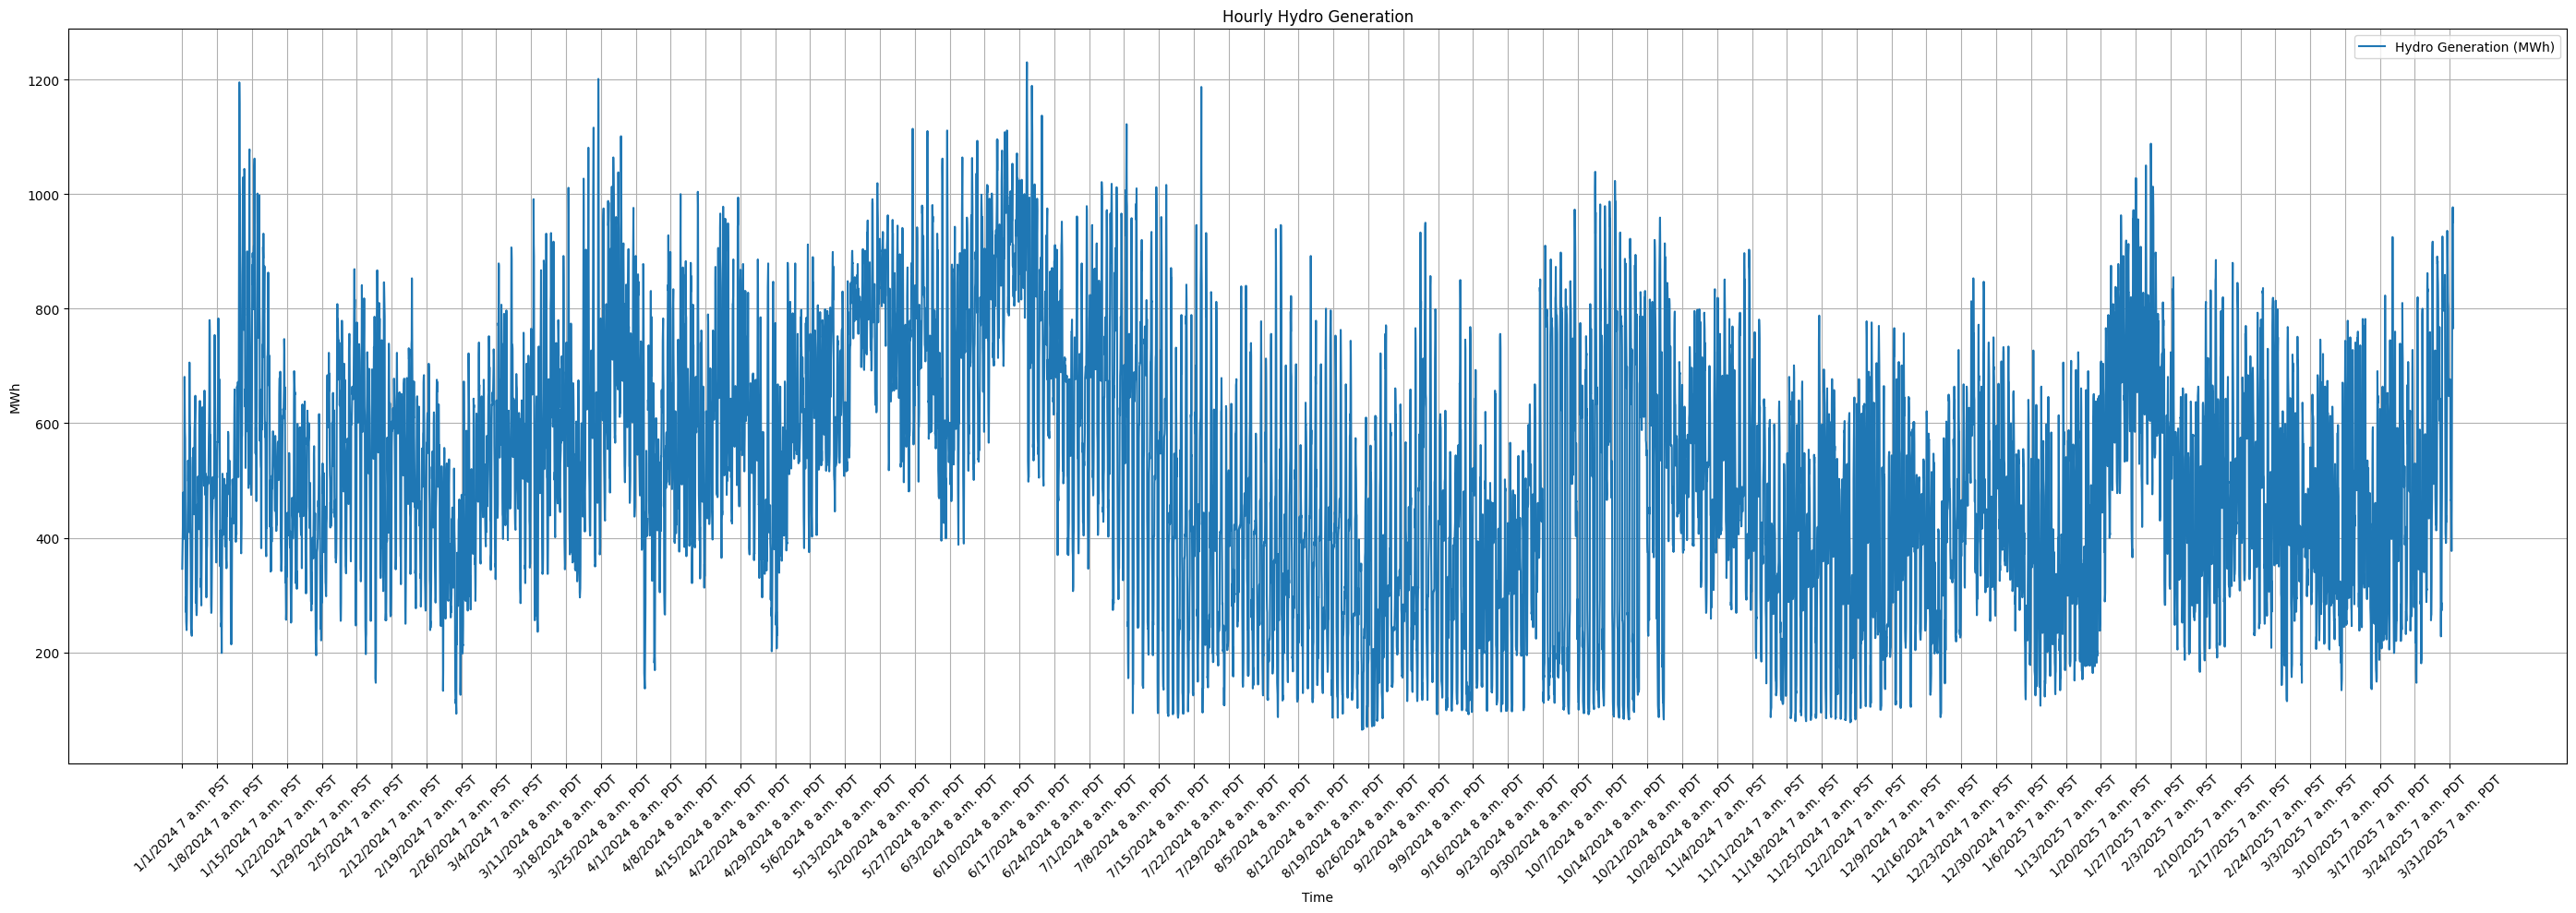

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

hydro_file = "hydro_data/seattle_hydro_jan24_mar25.csv"
df = pd.read_csv(hydro_file)

plt.figure(figsize=(28, 10))
plt.plot(df["Timestamp (Hour Ending)"], df["Hydro Generation (MWh)"], label="Hydro Generation (MWh)")

plt.title("Hourly Hydro Generation")
plt.xlabel("Time")
plt.ylabel("MWh")
plt.legend()
plt.grid(True)

# Show only every 6th label on x-axis (e.g., every 6 hours)
ticks_to_use = df["Timestamp (Hour Ending)"].iloc[::168]
plt.xticks(ticks_to_use, rotation=45)

plt.tight_layout()
plt.show()


## Plot weather variables to determine other patterns that can align with hydro generation

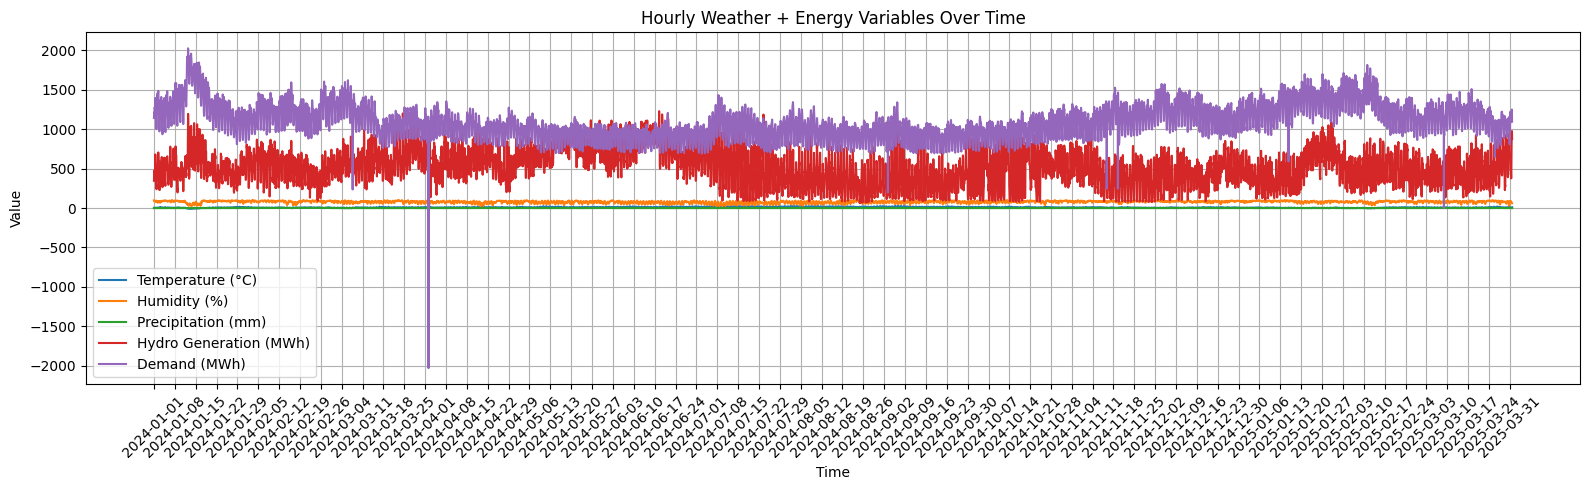

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("hydro_weather_data/seattle_hydro_weather_demand.csv")

# Convert the date column to datetime (if not already)
df["date"] = pd.to_datetime(df["date"])

# Plot multiple variables
plt.figure(figsize=(16,5))

plt.plot(df["date"], df["temperature_2m"], label="Temperature (°C)")
plt.plot(df["date"], df["relative_humidity_2m"], label="Humidity (%)")       # if this column exists
plt.plot(df["date"], df["precipitation"], label="Precipitation (mm)") 
plt.plot(df["date"], df["Hydro Generation (MWh)"], label="Hydro Generation (MWh)")
plt.plot(df["date"], df["Demand (MWh)"], label="Demand (MWh)")       

plt.title("Hourly Weather + Energy Variables Over Time")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Show only every 24th label on x-axis (e.g., daily)
ticks_to_use = df["date"].iloc[::168]
plt.xticks(ticks_to_use, rotation=45)

plt.tight_layout()
plt.show()


## Random Forest Model
- Including all previous variables along with some lagged variables to determine which features are the most significant.

c:\Users\saiha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 65.64
R² Score: 0.91
Error Percentage (RMSE): 12.85% 


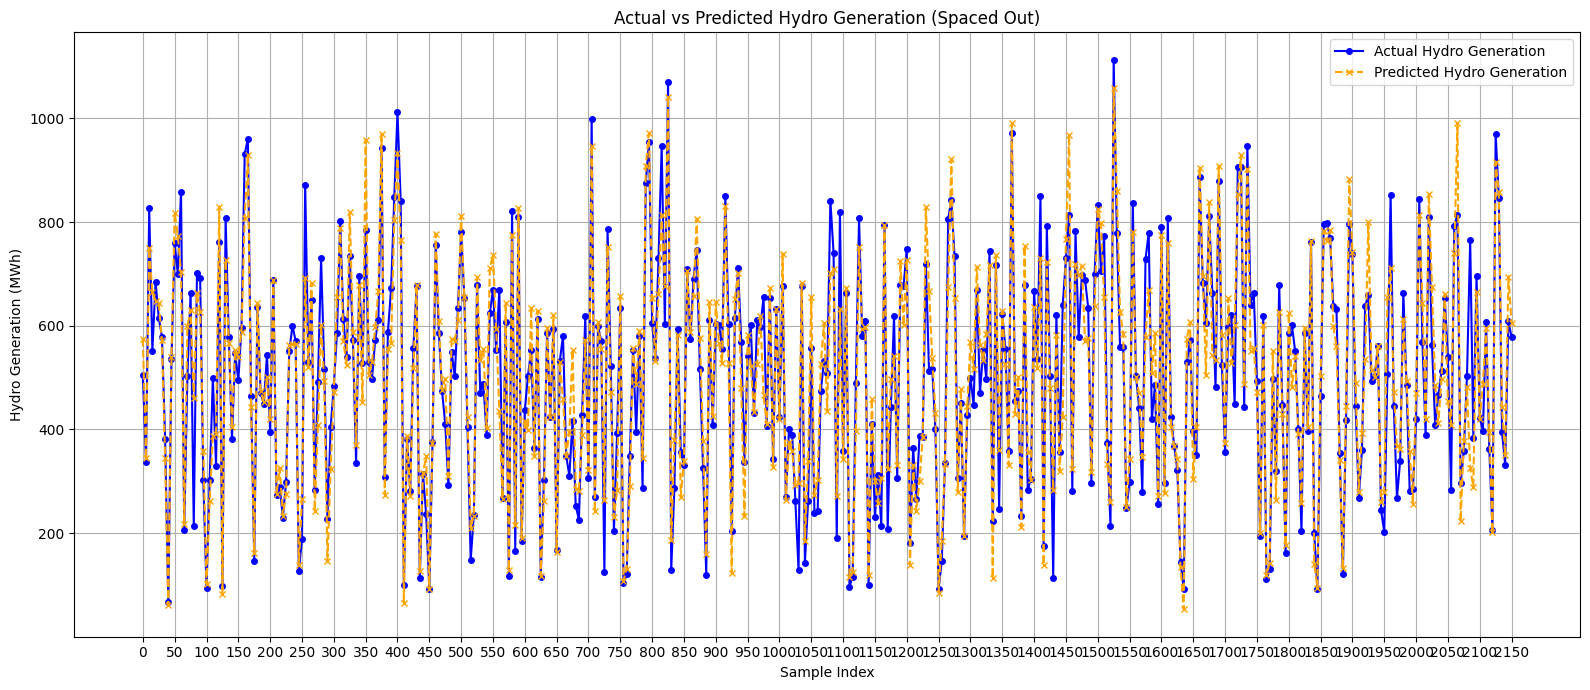

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np 
from xgboost import XGBRegressor

# Load the data
df = pd.read_csv('hydro_weather_data/seattle_hydro_weather_demand.csv')

df['date'] = pd.to_datetime(df['date'])

df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

df['hydro_lag_1'] = df['Hydro Generation (MWh)'].shift(1)
df['hydro_lag_24'] = df['Hydro Generation (MWh)'].shift(24)
df['hydro_lag_168'] = df['Hydro Generation (MWh)'].shift(168)

df['demand_1'] = df['Demand (MWh)'].shift(1)
df['demand_24'] = df['Demand (MWh)'].shift(24)
df['demand_168'] = df['Demand (MWh)'].shift(168)

df['precip_lag_3'] = df['precipitation'].shift(6)
df.dropna(inplace=True)

df['temperature_1'] = df['temperature_2m'].shift(1)
df['temperature_2'] = df['temperature_2m'].shift(2)
df['temperature_3'] = df['temperature_2m'].shift(3)
df['temperature_24'] = df['temperature_2m'].shift(24)
df['temperature_168'] = df['temperature_2m'].shift(168)

df['soil_1'] = df['soil_temperature_0_to_7cm'].shift(1)
df['soil_2'] = df['soil_temperature_0_to_7cm'].shift(2)
df['soil_3'] = df['soil_temperature_0_to_7cm'].shift(3)


df['relative_humidity_1'] = df['relative_humidity_2m'].shift(1)

df['rolling_temp'] = df['temperature_2m'].rolling(672).mean()
df['rolling_precip'] = df['precipitation'].rolling(168).mean()
df['rolling_soil'] = df['soil_temperature_0_to_7cm'].rolling(336).mean()
df['rolling_humidity'] = df['relative_humidity_2m'].rolling(168).mean()
df['rolling_demand'] = df['Demand (MWh)'].rolling(24).mean()
df['rolling_hydro'] = df['Hydro Generation (MWh)'].rolling(24).mean()


df["delta_temp"] = df["temperature_2m"].diff(672)
df["std_temp_24"] = df["temperature_2m"].rolling(3).std()


df["cum_snow_2w"] = df["precipitation"].rolling(96).sum()

# If weather_code is string/object type
df['weather_code'] = df['weather_code'].astype('category').cat.codes

features = [
    "hour", "Demand (MWh)", "soil_1", "rolling_temp", "rolling_precip", "rolling_soil", "rolling_humidity",
    "rolling_demand"
]

X = df[features]

y = df["Hydro Generation (MWh)"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# model = RandomForestRegressor()
model = XGBRegressor(n_estimators = 1000, 
                     learning_rate = 0.25, 
                     random_state = 42, 
                     subsample = 1, 
                     reg_alpha = 0.5)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(y_test, y_pred, squared=False) 
r2 = r2_score(y_test, y_pred)  

hydro_mean = df["Hydro Generation (MWh)"].mean()

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Error Percentage (RMSE): {(rmse / hydro_mean) * 100:.2f}% ")

import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 7))

# Plot every 5th point to reduce crowding
step = 5
x_axis = np.arange(len(y_test))
plt.plot(x_axis[::step], y_test.values[::step], label='Actual Hydro Generation', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(x_axis[::step], y_pred[::step], label='Predicted Hydro Generation', color='orange', marker='x', linestyle='--', markersize=4)

plt.title('Actual vs Predicted Hydro Generation (Spaced Out)')
plt.xlabel('Sample Index')
plt.ylabel('Hydro Generation (MWh)')
plt.legend()
plt.grid(True)

# Increase spacing between x-ticks
plt.xticks(ticks=x_axis[::step*10], labels=x_axis[::step*10])

plt.tight_layout()
plt.show()


